In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

import inflect

In [2]:
sqf_cpw_filter = pd.read_csv('./data/clean_sqf.csv')

In [3]:
p = inflect.engine()

sqf_cpw_filter['YEAR2'] = sqf_cpw_filter['YEAR2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['MONTH2'] = sqf_cpw_filter['MONTH2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['DAY2'] = sqf_cpw_filter['DAY2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['STOP_LOCATION_PRECINCT'] = sqf_cpw_filter['STOP_LOCATION_PRECINCT'].apply(lambda x: p.number_to_words(int(x)))

In [4]:
sqf_cpw_filter = sqf_cpw_filter.astype({'YEAR2': 'object',
                                        'STOP_LOCATION_PRECINCT': 'object',
                                        'LOCATION_IN_OUT_CODE': 'object', 'JURISDICTION_CODE': 'object',
                                        'OBSERVED_DURATION_MINUTES': 'float64', 
                                        'STOP_DURATION_MINUTES': 'float64',
                                        'OFFICER_IN_UNIFORM_FLAG': 'object', 'FRISKED_FLAG': 'object',
                                        'SUSPECT_SEX': 'object', 'SUSPECT_RACE_DESCRIPTION': 'object',
                                        'SUSPECT_REPORTED_AGE': 'float64', 'SUSPECT_BODY_BUILD_TYPE': 'object',
                                        'SUSPECT_WEIGHT': 'float64', 'WEAPON_FOUND_FLAG': 'object', 
                                        'MONTH2': 'string', 'DAY2': 'string',
                                        'STOP_FRISK_TIME': 'float64'
                                        })

In [24]:
sqf_cpw_filter = sqf_cpw_filter.drop(columns='FRISKED_FLAG')

KeyError: "['FRISKED_FLAG'] not found in axis"

In [6]:
# simple imputation, defining the functions

def fill_missing_data(df):
    num_cols = df.select_dtypes(['float64', 'int64'])
    cat_cols = df.select_dtypes(['object', 'string'])
    for col in num_cols:
        df[col] = df[col].fillna(df[col].mean())
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])    
    return df

In [7]:
# calling function

df_filled = fill_missing_data(sqf_cpw_filter)

In [8]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13031 entries, 0 to 13030
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR2                      13031 non-null  object 
 1   STOP_LOCATION_PRECINCT     13031 non-null  object 
 2   LOCATION_IN_OUT_CODE       13031 non-null  object 
 3   JURISDICTION_CODE          13031 non-null  object 
 4   OBSERVED_DURATION_MINUTES  13031 non-null  float64
 5   STOP_DURATION_MINUTES      13031 non-null  float64
 6   OFFICER_IN_UNIFORM_FLAG    13031 non-null  object 
 7   STOP_WAS_INITIATED         13031 non-null  object 
 8   SUSPECT_SEX                13031 non-null  object 
 9   SUSPECT_RACE_DESCRIPTION   13031 non-null  object 
 10  SUSPECT_REPORTED_AGE       13031 non-null  float64
 11  SUSPECT_WEIGHT             13031 non-null  float64
 12  SUSPECT_BODY_BUILD_TYPE    13031 non-null  object 
 13  WEAPON_FOUND_FLAG          13031 non-null  flo

In [9]:
dic = {'Y': 1, 'N': 0}

df = sqf_cpw_filter.replace({'OFFICER_IN_UNIFORM_FLAG': dic})
df = sqf_cpw_filter.replace({'STOP_WAS_INITIATED': dic})
df = df.drop(['OBSERVED_DURATION_MINUTES'], axis=1)

## Implementing RF

In [10]:
ohe_cols =['YEAR2', 'STOP_LOCATION_PRECINCT','LOCATION_IN_OUT_CODE', 'OFFICER_IN_UNIFORM_FLAG', 'STOP_WAS_INITIATED', 'JURISDICTION_CODE', 
           'SUSPECT_SEX', 'WEAPON_FOUND_FLAG', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_BODY_BUILD_TYPE', 'MONTH2', 'DAY2']

df_ohe = pd.get_dummies(df, prefix=ohe_cols, columns=ohe_cols, drop_first=True)

In [11]:
df_ohe.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13031 entries, 0 to 13030
Data columns (total 119 columns):
 #    Column                                               Non-Null Count  Dtype  
---   ------                                               --------------  -----  
 0    STOP_DURATION_MINUTES                                13031 non-null  float64
 1    SUSPECT_REPORTED_AGE                                 13031 non-null  float64
 2    SUSPECT_WEIGHT                                       13031 non-null  float64
 3    SUSPECT_HEIGHT                                       13031 non-null  float64
 4    STOP_FRISK_TIME                                      13031 non-null  float64
 5    YEAR2_two thousand and fifteen                       13031 non-null  uint8  
 6    YEAR2_two thousand and nineteen                      13031 non-null  uint8  
 7    YEAR2_two thousand and seventeen                     13031 non-null  uint8  
 8    YEAR2_two thousand and sixteen                       1

In [12]:
weapon = 'WEAPON_FOUND_FLAG_1.0'
estimators = 1000
depth=50

# split

train, test = train_test_split(df_ohe, train_size=0.8, random_state=1)

train, val = train_test_split(train, test_size=0.5, random_state=1)

# targets
Y_train = train[weapon]
Y_val = val[weapon]
Y_test = test[weapon]

X_train = train.drop([weapon], axis=1)
X_val = val.drop([weapon], axis=1)
X_test = test.drop([weapon], axis=1)
    
# # define the model
# model = RandomForestClassifier(random_state=1)

# # fit the model
# model.fit(X_train, Y_train)

# # evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(model, X_test, Y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))

# # get importance
# importances = model.feature_importances_

#### Plotting Val Curve

In [13]:
X = df_ohe.drop([weapon], axis=1)
y = df_ohe[weapon]

In [14]:
def weighted_accuracy(true, pred):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos 
    frac_pos = num_pos/num_labels 
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    #print(weight_pos)
    #print(weight_neg)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true): 
        num_pos_correct += (pred_i == true_i and true_i == 1) 
        num_neg_correct += (pred_i == true_i and true_i == 0) 
        weighted_accuracy = ((weight_pos * num_pos_correct) 
                             + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg)) 
    return weighted_accuracy 

In [15]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import fbeta_score, make_scorer

# n_estimators = [300]
# max_depth = [5, 10, 15]
# min_samples_split = [2, 3, 4]
# min_samples_leaf = [1, 2] 
# max_features = [15, 20, 25]

# score = make_scorer(weighted_accuracy, greater_is_better=True)

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf,
#              max_features = max_features)

# model = RandomForestClassifier()

# gridF = GridSearchCV(model, hyperF, cv = None, verbose = 1, scoring=score)
# bestF = gridF.fit(X_train, Y_train)

In [16]:
# bestF.best_params_

In [17]:
best_rfc = RandomForestClassifier(max_depth=15, max_features=25, min_samples_leaf=1, min_samples_split=3,
 n_estimators=300, n_jobs=-1, class_weight="balanced")

# fit the model
best_rfc.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=25,
                       min_samples_split=3, n_estimators=300, n_jobs=-1)

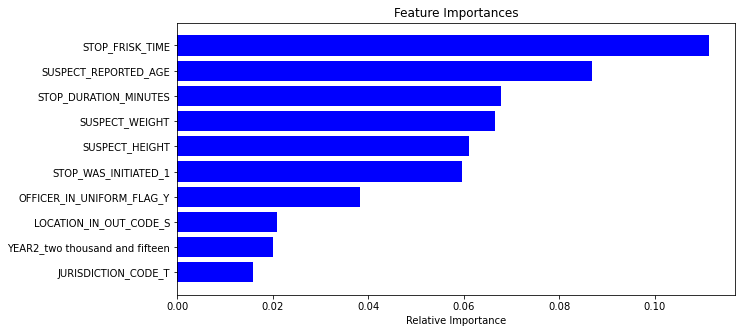

In [18]:
X = df_ohe.drop([weapon], axis=1)
y = df_ohe[weapon]

# features = [f"feature {i}" for i in range(X.shape[1])]
# forest_importances = pd.Series(importances, index=feature_names)
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# plt.figure(figsize=(20,20))
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

features = X.columns
importances = best_rfc.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 10 

plt.figure(figsize=(10, 5))
plt.title('Feature Importances')

plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [21]:
X = df_ohe.drop([weapon], axis=1)
y = df_ohe[weapon]

In [22]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

param_range = np.arange(1,90, step=2)
train_scores, valid_scores = validation_curve(RandomForestClassifier(), X, y, param_name="max_depth", param_range=param_range,
                                             scoring=weighted_accuracy(estimator, X, y))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, valid_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

NameError: name 'estimator' is not defined

### Performance Evaluation

1. Confusion Matrix
2. Classification Report

Bonus: tree viz

#### Confusion Matrix

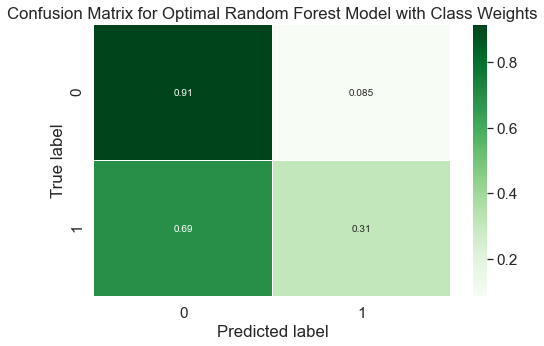

In [23]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Y_train = train[weapon]
Y_val = val[weapon]
Y_test = test[weapon]

X_train = train.drop([weapon], axis=1)
X_val = val.drop([weapon], axis=1)
X_test = test.drop([weapon], axis=1)

Y_pred_val = best_rfc.predict(X_val)
Y_pred_test = best_rfc.predict(X_test)
Y_pred_train = best_rfc.predict(X_train)

# Get and reshape confusion matrix data
matrix = confusion_matrix(Y_val, Y_pred_val)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(8,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Optimal Random Forest Model with Class Weights')
plt.show()

#### Classification Report

In [ ]:
def weighted_accuracy(true, pred):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos 
    frac_pos = num_pos/num_labels 
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    #print(weight_pos)
    #print(weight_neg)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true): 
        num_pos_correct += (pred_i == true_i and true_i == 1) 
        num_neg_correct += (pred_i == true_i and true_i == 0) 
        weighted_accuracy = ((weight_pos * num_pos_correct) 
                             + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg)) 
    return weighted_accuracy 

In [ ]:
print(weighted_accuracy(Y_test, Y_pred_test))

In [ ]:
print(weighted_accuracy(Y_val, Y_pred_val))

In [ ]:
print(weighted_accuracy(Y_train, Y_pred_train))

In [ ]:
print(classification_report(Y_test, Y_pred_test))

In [28]:
# Train
best_rfc.fit(X_train, Y_train)
# Extract single tree
estimator = best_rfc.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = None,
                class_names = None,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# "Appendix"

## RF with oversampling and undersampling

In [ ]:
# # using the non-one-hot-encoded data

# train, test = train_test_split(df_ohe, test_size=0.2, random_state=1)
# train, val = train_test_split(train, test_size=0.25, random_state=1)

# weapon = 'WEAPON_FOUND_FLAG_1.0'

# # targets
# Y_train = train[weapon]
# Y_val = val[weapon]
# Y_test = test[weapon]

# X_train = train.drop([weapon], axis=1)
# X_val = val.drop([weapon], axis=1)
# X_test = test.drop([weapon], axis=1)
    
# # define the model
# model = RandomForestRegressor(max_depth=100)

In [ ]:
# df_ohe

In [ ]:
# categorical = np.arange(6, 119, 1)

In [ ]:
# # Oversample and plot imbalanced dataset with SMOTE
# from imblearn.over_sampling import SMOTENC

# over = SMOTENC(categorical_features=categorical)
# under = RandomUnderSampler()
# # define pipeline
# pipeline = Pipeline(steps=[('o', over), ('u', under)])
# X_res, Y_res = pipeline.fit_resample(X_train, Y_train)
# # # summarize the new class distribution
# # counter = Counter(y)
# # print(counter)

# # evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline, X_res, Y_res, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))

In [ ]:
# fit the model
# model.fit(X_res, Y_res)

In [ ]:
# from sklearn.metrics import accuracy_score
# print('acc train = ', accuracy_score(Y_res, model.predict(X_res))) 